<center><h1>Optimal Tiling Experiment Notebook</h1></center>
<center><h2>Matthias Bartolo</h2></center>

**<h3>Packages</h3>**

In [1]:
# !pip install roboflow

In [2]:
import os
import json
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from roboflow import Roboflow
import glob
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import pandas as pd

**<h3>Downloading the dataset from Roboflow</h3>**

In [3]:
download_datasets = False # True
if download_datasets:
    import os
    import json
    from roboflow import Roboflow

    HOME = os.getcwd()
    # Go back one directory to the root of the project
    HOME = os.path.dirname(HOME)
    print("Downloading datasets to: ", os.path.join(HOME, 'datasets'))

    if not os.path.isdir(os.path.join(HOME, 'datasets')):
        os.mkdir(os.path.join(HOME, 'datasets'))
    os.chdir(os.path.join(HOME, 'datasets'))

    ########################################################## ROBOFLOW ##########################################################
    # SODA Dataset
    rf = Roboflow(api_key="nyynHs3oneLLx01D04rC")
    # project = rf.workspace("soda-dataset").project("01m-all")
    # version = project.version(1)
    # dataset = version.download("coco")

    project = rf.workspace("soda-dataset").project("soda-litter-dataset-all")
    version = project.version(1)
    dataset = version.download("coco")

    # project = rf.workspace("soda-dataset").project("soda-litter-dataset-05m-30m")
    # version = project.version(1)
    # dataset = version.download("coco")

    ########################################################## ROBOFLOW ##########################################################

    # Ensure correct folder structure
    directories = ['train', 'valid', 'test']
    # Change the directories to get the full path
    directories = [os.path.join(dataset.location, directory) for directory in directories]

    for directory in directories:
        os.makedirs(f'{directory}/images', exist_ok=True)  # Create 'images' subfolder

    # Move images to corresponding 'images' subfolders while keeping annotations in the main split folder
    for directory in directories:
        image_dir = os.path.join(dataset.location, directory)  # Original dataset directory
        dest_image_dir = f'{directory}/images'  # Destination images folder

        annotation_file = os.path.join(image_dir, "_annotations.coco.json")
        new_annotation_path = os.path.join(directory, "_annotations.coco.json")

        for file_name in os.listdir(image_dir):  # Iterate over files in the dataset split
            src_path = os.path.join(image_dir, file_name)

            if file_name.endswith('.jpg') or file_name.endswith('.png'):  # Move images
                dest_path = os.path.join(dest_image_dir, file_name)
            elif file_name == "_annotations.coco.json":  # Keep annotations in the main split folder
                dest_path = new_annotation_path
            else:
                continue  # Ignore other file types

            if os.path.isfile(src_path):  # Ensure it's a file before moving
                os.rename(src_path, dest_path)

        # Update _annotations.coco.json to reflect the new image paths
        if os.path.isfile(new_annotation_path):
            with open(new_annotation_path, 'r') as f:
                data = json.load(f)

            for image in data["images"]:
                image["file_name"] = f"{image['file_name']}"  # Update path in annotation

            with open(new_annotation_path, 'w') as f:
                json.dump(data, f, indent=4)  # Save the updated JSON

**<h3>Defining Paths and Constants</h3>**

In [ ]:
# Defining paths
dataset_path = '../datasets/SODA-Litter-Dataset-05m-30m-1'
img_resize = 640 #800

**<h3>Tiling Experiment</h3>**

In [5]:
tiles =[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]
grid_split = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tile_results_dict = {tile: {'Number of images': 0, 'Number of annotations': 0, 'Number of Small objects': 0, 'Number of Medium objects': 0, 'Number of Large objects': 0} for tile in tiles}

def categorize_object_size(width, height):
    """Classify object size based on area."""
    area = width * height
    if area < 32**2:
        return "Small"
    elif area < 96**2:
        return "Medium"
    else:
        return "Large"

def resize_annotations(annotations, original_size, new_size):
    """Resize annotation bounding boxes based on new image dimensions."""
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    
    resized_annotations = []
    for anno in annotations:
        x, y, w, h = anno['bbox']
        new_x, new_y = x * scale_x, y * scale_y
        new_w, new_h = w * scale_x, h * scale_y
        resized_annotations.append({'category_id': anno['category_id'], 'bbox': [new_x, new_y, new_w, new_h]})
    
    return resized_annotations

def split_image(image, annotations, tile):
    """Split image into tiles and adjust annotations accordingly."""
    img_h, img_w = image.shape[:2]

    if tile == 1:
        resized_image = cv2.resize(image, (img_resize, img_resize))
        resized_annotations = resize_annotations(annotations, (img_w, img_h), (img_resize, img_resize))
        return [(resized_image, resized_annotations)]
    
    grid_size = int(tile**0.5)
    tile_h, tile_w = img_h // grid_size, img_w // grid_size
    split_images = []

    for i in range(grid_size):
        for j in range(grid_size):
            x1, y1 = j * tile_w, i * tile_h
            x2, y2 = x1 + tile_w, y1 + tile_h

            tile_img = image[y1:y2, x1:x2]
            tile_img = cv2.resize(tile_img, (img_resize, img_resize))
            
            tile_annotations = []
            for anno in annotations:
                x, y, w, h = anno['bbox']
                x_max, y_max = x + w, y + h

                # Check if the bounding box intersects with the tile
                if x_max > x1 and x < x2 and y_max > y1 and y < y2:
                    new_x = max(x - x1, 0) * img_resize / tile_w
                    new_y = max(y - y1, 0) * img_resize / tile_h
                    new_w = min(x_max, x2) - max(x, x1)
                    new_h = min(y_max, y2) - max(y, y1)
                    new_w, new_h = new_w * img_resize / tile_w, new_h * img_resize / tile_h
                    
                    if new_w > 0 and new_h > 0:
                        tile_annotations.append({'category_id': anno['category_id'], 'bbox': [new_x, new_y, new_w, new_h]})
            
            split_images.append((tile_img, tile_annotations))
    
    return split_images

def optimal_tiling_experiment(dataset_path):
    """Run the tiling experiment and process dataset."""
    subsets = ['train', 'valid', 'test']
    for subset in subsets:
        coco_annotation_file = os.path.join(dataset_path, subset, '_annotations.coco.json')
        
        with open(coco_annotation_file, 'r') as f:
            coco_data = json.load(f)
        
        category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
        img_dir = os.path.join(dataset_path, subset, 'images')
        image_name_to_id = {img['file_name']: img['id'] for img in coco_data['images']}
        
        image_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
        
        for img_file in tqdm(image_files, desc=f"Processing {subset} images", unit="image"):
            img_name = os.path.basename(img_file)
            if img_name not in image_name_to_id:
                print(f"Warning: {img_name} not found in COCO annotations.")
                continue
            
            image_id = image_name_to_id[img_name]
            img = cv2.imread(img_file)
            img_annotations = [anno for anno in coco_data['annotations'] if anno['image_id'] == image_id]
            
            for tile in tiles:
                split_images = split_image(img, img_annotations, tile)
                
                tile_results_dict[tile]['Number of images'] += len(split_images)
                
                for _, annotations in split_images:
                    tile_results_dict[tile]['Number of annotations'] += len(annotations)
                    for anno in annotations:
                        w, h = anno['bbox'][2], anno['bbox'][3]
                        category = categorize_object_size(w, h)
                        tile_results_dict[tile][f'Number of {category} objects'] += 1

optimal_tiling_experiment(dataset_path)
print(tile_results_dict)


Processing test images: 100%|██████████| 75/75 [00:09<00:00,  7.73image/s]

{1: {'Number of images': 377, 'Number of annotations': 6039, 'Number of Small objects': 5764, 'Number of Medium objects': 275, 'Number of Large objects': 0}, 4: {'Number of images': 1508, 'Number of annotations': 6467, 'Number of Small objects': 4871, 'Number of Medium objects': 1566, 'Number of Large objects': 30}, 9: {'Number of images': 3393, 'Number of annotations': 6581, 'Number of Small objects': 3905, 'Number of Medium objects': 2437, 'Number of Large objects': 239}, 16: {'Number of images': 6032, 'Number of annotations': 6947, 'Number of Small objects': 3119, 'Number of Medium objects': 3150, 'Number of Large objects': 678}, 25: {'Number of images': 9425, 'Number of annotations': 7243, 'Number of Small objects': 2336, 'Number of Medium objects': 3753, 'Number of Large objects': 1154}, 36: {'Number of images': 13572, 'Number of annotations': 7408, 'Number of Small objects': 1687, 'Number of Medium objects': 4043, 'Number of Large objects': 1678}, 49: {'Number of images': 18473, 

,Number of images,Number of annotations,Number of Small objects,Number of Medium objects,Number of Large objects,Grid split,Resize
1,377,6039,5764,275,0,1,640
4,1508,6467,4871,1566,30,2,640
9,3393,6581,3905,2437,239,3,640
16,6032,6947,3119,3150,678,4,640
25,9425,7243,2336,3753,1154,5,640
36,13572,7408,1687,4043,1678,6,640
49,18473,7831,1293,4430,2108,7,640
64,24128,8105,931,4536,2638,8,640
81,30537,8391,695,4585,3111,9,640
100,37700,8759,637,4483,3639,10,640


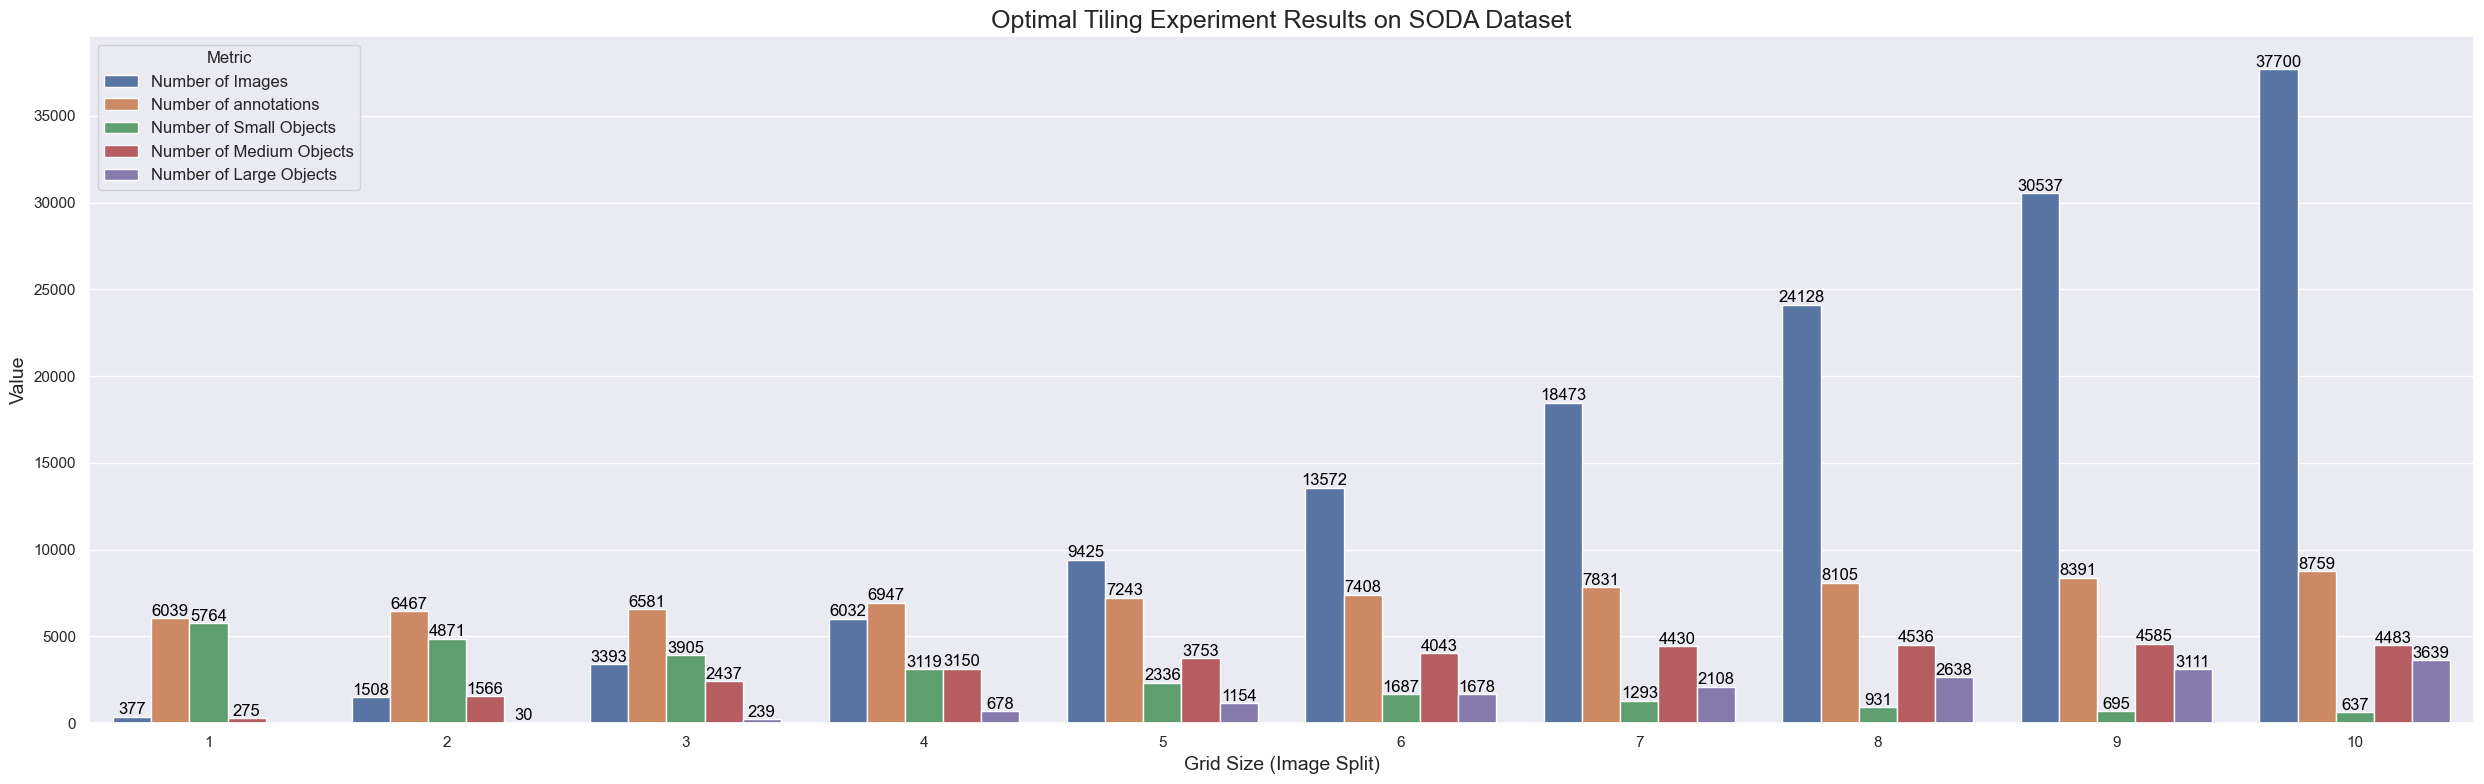

In [6]:
# change to pandas dataframe for visualization
results_df = pd.DataFrame(tile_results_dict).T
# add grid split column
results_df['Grid split'] = grid_split
# Add resize column
results_df['Resize'] = img_resize

display(results_df)
# Save results to CSV
results_df.to_csv('optimal_tiling_experiment_results.csv', index=True)

# Melt the DataFrame to plot easily with seaborn
results_melted = pd.melt(results_df.drop(columns='Resize'), id_vars='Grid split', var_name='Metric', value_name='Value')

# Plotting the barplot
sns.set_theme(style="darkgrid")
plt.figure(figsize=(25, 8))

# Create the barplot with dodge=True for spacing between subcolumns
ax = sns.barplot(x='Grid split', y='Value', hue='Metric', data=results_melted, dodge=True, width=0.8)

# Set the title and labels
ax.set_title('Optimal Tiling Experiment Results on SODA Dataset', fontsize=18)
ax.set_xlabel('Grid Size (Image Split)', fontsize=14)
ax.set_ylabel('Value', fontsize=14)

# Adding data labels on top of the bars with adjusted position to avoid overlapping
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if the bar has a positive height
        ax.annotate(f'{height:.0f}', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='center', fontsize=12, color='black', 
                    xytext=(0, 5), textcoords='offset points')

# Capitalize the legend labels (capitalize only the desired words)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, 
          [label.replace('images', 'Images')
           .replace('small', 'Small')
           .replace('medium', 'Medium')
           .replace('large', 'Large')
           .replace('objects', 'Objects') 
           for label in labels], 
          title='Metric', fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('optimal_tiling_experiment_results.png')
plt.show()


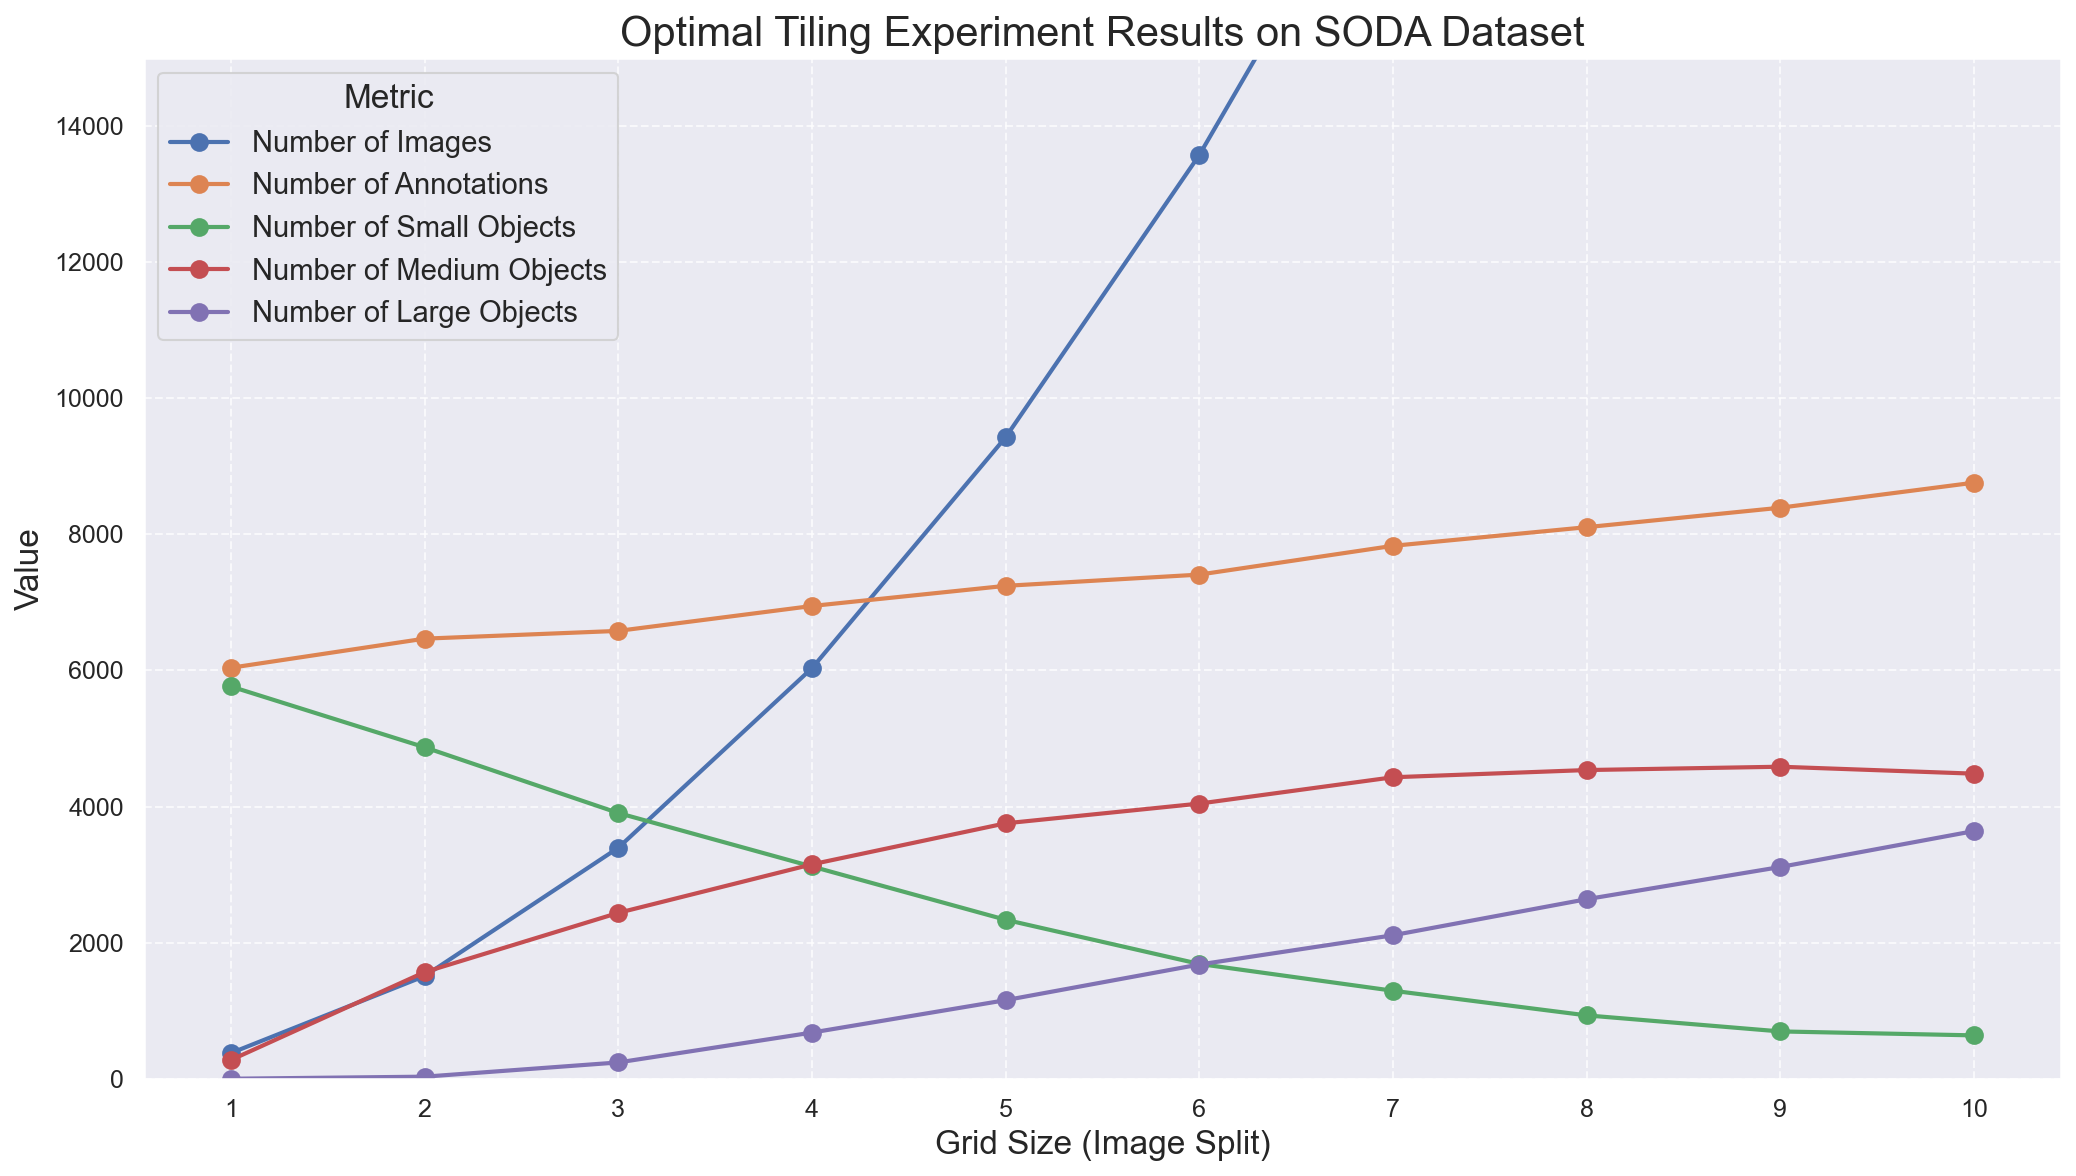

In [7]:
# Plotting the line graph for all the variables with higher resolution
plt.figure(figsize=(14, 8), dpi=150)  # Increased resolution (dpi)

# Plot each variable against the number of grid splits
plt.plot(results_df['Grid split'], results_df['Number of images'], label='Number of Images', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(results_df['Grid split'], results_df['Number of annotations'], label='Number of Annotations', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(results_df['Grid split'], results_df['Number of Small objects'], label='Number of Small Objects', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(results_df['Grid split'], results_df['Number of Medium objects'], label='Number of Medium Objects', marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(results_df['Grid split'], results_df['Number of Large objects'], label='Number of Large Objects', marker='o', markersize=8, linestyle='-', linewidth=2)

# Add labels and title
plt.title('Optimal Tiling Experiment Results on SODA Dataset', fontsize=20)
plt.xlabel('Grid Size (Image Split)', fontsize=16)
plt.ylabel('Value', fontsize=16)

# Set the ylimit and x-ticks to match the Grid Split values
plt.ylim(0, 15000)
plt.xticks(results_df['Grid split'], fontsize=12)
plt.yticks(fontsize=12)

# Add gridlines and make sure the lines are clear and visible
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust legend to be consistent with previous plots
plt.legend(title='Metric', fontsize=14, title_fontsize=16, loc='upper left')

# Tighten the layout for better spacing
plt.tight_layout()

# Save the plot
plt.savefig('optimal_tiling_experiment_results_line.png')

# Show the plot
plt.show()


,Number of images,Number of annotations,Number of Small objects,Number of Medium objects,Number of Large objects,Grid split,Resize,Ratio of Small Objects to Number of Images,Gradient Difference,Second Derivative of Gradient Difference
1,377,6039,5764,275,0,1,640,15.289125,NaN,NaN
4,1508,6467,4871,1566,30,2,640,3.230106,-12.059019,NaN
9,3393,6581,3905,2437,239,3,640,1.150899,-2.079207,9.979811
16,6032,6947,3119,3150,678,4,640,0.517076,-0.633823,1.445384
25,9425,7243,2336,3753,1154,5,640,0.247851,-0.269224,0.364599
36,13572,7408,1687,4043,1678,6,640,0.124300,-0.123551,0.145673
49,18473,7831,1293,4430,2108,7,640,0.069994,-0.054306,0.069245
64,24128,8105,931,4536,2638,8,640,0.038586,-0.031408,0.022898
81,30537,8391,695,4585,3111,9,640,0.022759,-0.015827,0.015582
100,37700,8759,637,4483,3639,10,640,0.016897,-0.005863,0.009964


Optimal Grid Split based on maximum curvature (elbow method): 3


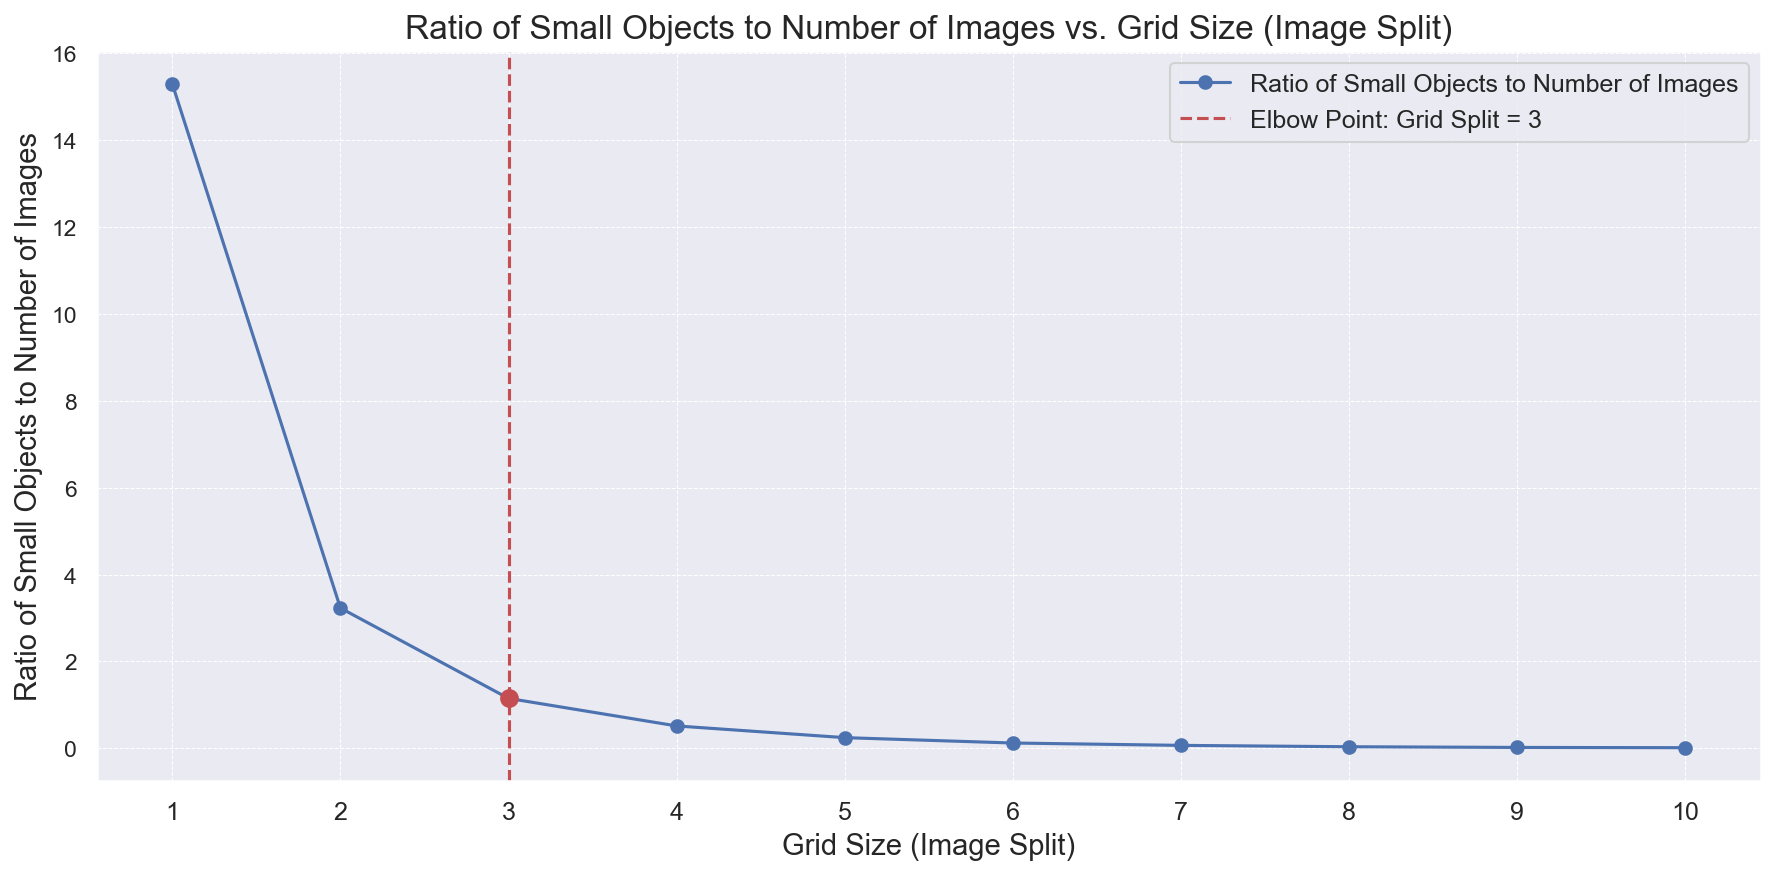

In [8]:
# Load the results from the CSV file
results_df = pd.read_csv('optimal_tiling_experiment_results.csv', index_col=0)

# Calculate the ratio of small objects to number of images
results_df['Ratio of Small Objects to Number of Images'] = results_df['Number of Small objects'] / results_df['Number of images']

# Compute the difference between consecutive ratios to get the rate of change (gradient difference)
results_df['Gradient Difference'] = results_df['Ratio of Small Objects to Number of Images'].diff()

# Compute the second derivative of the gradient difference (curvature)
results_df['Second Derivative of Gradient Difference'] = results_df['Gradient Difference'].diff()

# Find the point of maximum curvature (where the second derivative is maximized)
second_derivative_change = results_df['Second Derivative of Gradient Difference']
elbow_index = np.argmax(np.abs(second_derivative_change))  # Find the index of maximum curvature

# Get the corresponding grid split for the elbow point
optimal_split = int(results_df.iloc[elbow_index]['Grid split'])

# Display the DataFrame with ratios, gradient differences, and second derivatives
display(results_df)

print(f"Optimal Grid Split based on maximum curvature (elbow method): {optimal_split}")

# Plotting the Ratio of Small Objects to Number of Images with the optimal split marked
plt.figure(figsize=(12, 6), dpi=150)  # Increased resolution for better clarity
plt.plot(results_df['Grid split'], results_df['Ratio of Small Objects to Number of Images'], marker='o', color='b', label='Ratio of Small Objects to Number of Images')

# Add vertical line for optimal split
plt.axvline(x=optimal_split, color='r', linestyle='--', label=f'Elbow Point: Grid Split = {optimal_split}')

# Place a marker at the elbow point
plt.plot(optimal_split, results_df.iloc[elbow_index]['Ratio of Small Objects to Number of Images'], marker='o', markersize=8, color='r')

# Set the title and labels
plt.title('Ratio of Small Objects to Number of Images vs. Grid Size (Image Split)', fontsize=16)
plt.xlabel('Grid Size (Image Split)', fontsize=14)
plt.ylabel('Ratio of Small Objects to Number of Images', fontsize=14)

# Improve x-axis ticks to show all grid splits
plt.xticks(results_df['Grid split'], fontsize=12)

# Add horizontal and vertical gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend
plt.legend(fontsize=12)

# Adjust layout to prevent clipping
plt.tight_layout()

# Save the plot
plt.savefig('optimal_tiling_experiment_elbow_method.png')

# Show the plot
plt.show()
